In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/deepl_learning/fineTuning

/gdrive/MyDrive/deepl_learning/fineTuning


## Import libraries

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

tfk = tf.keras
tfkl = tf.keras.layers

## Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Initialization

In [ ]:
# Create a dictionary

label_dict = {
    0: 'Apple',
    1: 'Blueberry',
    2: 'Cherry', 
    3: 'Corn',
    4: 'Grape',
    5:'Orange',
    6: 'Peach', 
    7:'Pepper',
    8: 'Potato',
    9: 'Raspberry',
    10: 'Soybean',
    11: 'Squash',
    12: 'Strawberry',
    13: 'Tomato'
    }

In [ ]:
!unzip dataset.zip

In [ ]:
dataset_dir = 'training'

In [ ]:
# Use only if the shape of the image must be changed: it resizes the images
img_list = []
label_list = []


for key, label in label_dict.items():
  for _, _, filenames in os.walk('{}/{}/'.format(dataset_dir, label)): 
    for class_image in tqdm(filenames, desc=label):
      img = Image.open('{}/{}/{}'.format(dataset_dir, label, class_image))
      img = img.resize((112,112)) #resize of the image

      img_list.append(np.array(img))
      label_list.append(key)

img_list = np.array(img_list)
label_list = np.array(label_list)

In [ ]:
# Find broken images
broken_imgs = []
for i, im in enumerate(img_list):
  if im.shape != (112, 112, 3):
    broken_imgs.append(i)

In [ ]:
'''
print('Number of broken images: {}'.format(len(broken_imgs)))
print('Number of images: {}'.format(len(img_list)))
'''

In [ ]:
# Delete broken images
if len(broken_imgs) > 0:
  for b in broken_imgs:
    img_list.pop(b)
    label_list.pop(b)

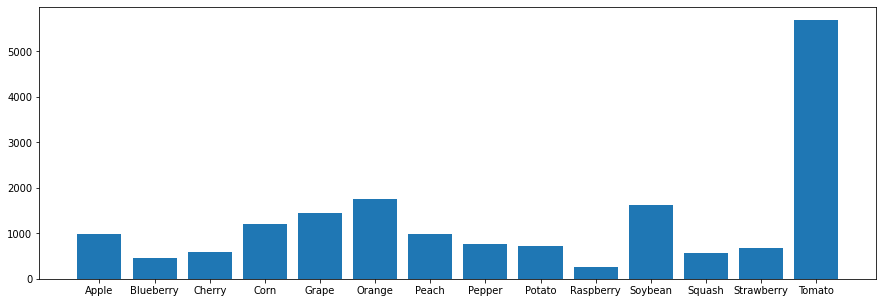

In [ ]:
# Show the distribution of the classes
cnts = np.unique(label_list, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(x=label_dict.values(), height=cnts[1])
plt.show()

## Preprocessing of data

In [ ]:
# Convert the labels from int to categorical since we have a multiclass problem
label_list= tfk.utils.to_categorical(label_list)

In [ ]:
# set batch size and number of epochs
batch_size = 8
epochs = 200

In [ ]:
# split the data:

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
X_remaining, X_test, y_remaining, y_test = train_test_split( img_list, label_list, test_size=ratio_test, random_state=seed, stratify=label_list)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=ratio_val_adjusted, random_state=seed, stratify=y_remaining)


## Transfer learning

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

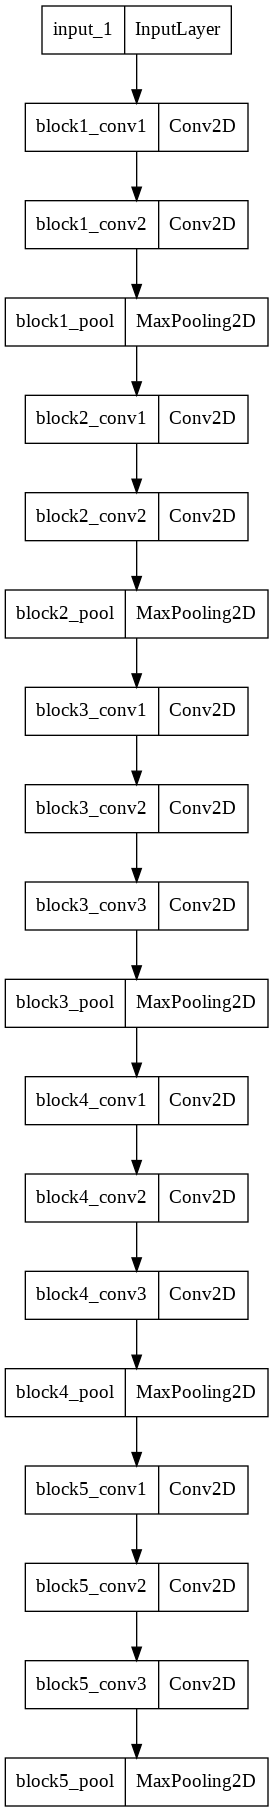

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet"
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

input_layer = tfkl.Input(shape=(112,112,3), name='Input')

vgg = supernet(input_layer)

gap = tfkl.GlobalAveragePooling2D()(vgg)

flat = tfkl.Flatten(name='Flattening')(gap)

drop1 = tfkl.Dropout(0.3, seed=seed)(flat)

dense1 = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(drop1)

drop2 = tfkl.Dropout(0.3, seed=seed)(dense1)

dense2 = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(drop2)

drop3 = tfkl.Dropout(0.2, seed=seed)(dense2)

outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(drop3)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 Flattening (Flatten)        (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                             

In [ ]:
# Delete the list of images and the list of labels to have more space
del img_list
del label_list

Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

datagen = ImageDataGenerator(
    rotation_range=45,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='nearest', 
    preprocessing_function=preprocess_input
)

training_generator = datagen.flow(X_train, y_train, batch_size=batch_size, seed=seed)
validation_generator = datagen.flow(X_val, y_val, seed=seed)


execution and evaluation

In [ ]:
# Train the model

tl_history = tl_model.fit(
    training_generator, 
    epochs= epochs, 
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
1773/1773 [==============================] - 102s 52ms/step - loss: 2.5666 - accuracy: 0.4357 - val_loss: 1.1345 - val_accuracy: 0.6870
Epoch 2/200
1773/1773 [==============================] - 89s 50ms/step - loss: 1.3795 - accuracy: 0.5788 - val_loss: 0.8798 - val_accuracy: 0.7501
Epoch 3/200
1773/1773 [==============================] - 87s 49ms/step - loss: 1.1371 - accuracy: 0.6425 - val_loss: 0.7230 - val_accuracy: 0.8026
Epoch 4/200
1773/1773 [==============================] - 87s 49ms/step - loss: 0.9850 - accuracy: 0.6887 - val_loss: 0.6503 - val_accuracy: 0.8139
Epoch 5/200
1773/1773 [==============================] - 86s 48ms/step - loss: 0.9245 - accuracy: 0.7019 - val_loss: 0.6007 - val_accuracy: 0.8319
Epoch 6/200
1773/1773 [==============================] - 85s 48ms/step - loss: 0.8482 - accuracy: 0.7267 - val_loss: 0.5537 - val_accuracy: 0.8477
Epoch 7/200
1773/1773 [==============================] - 86s 49ms/step - loss: 0.7837 - accuracy: 0.7452 - val_loss: 

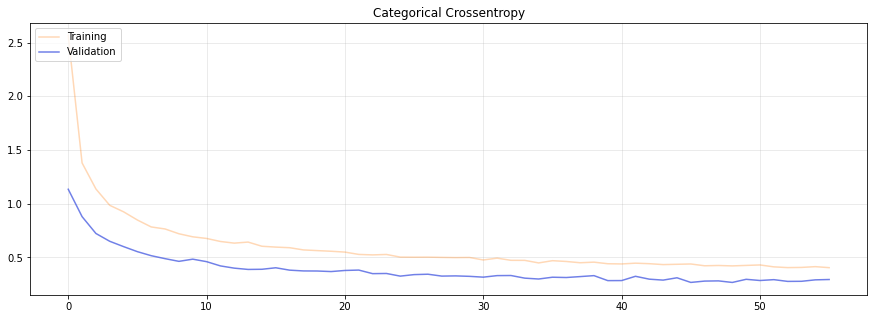

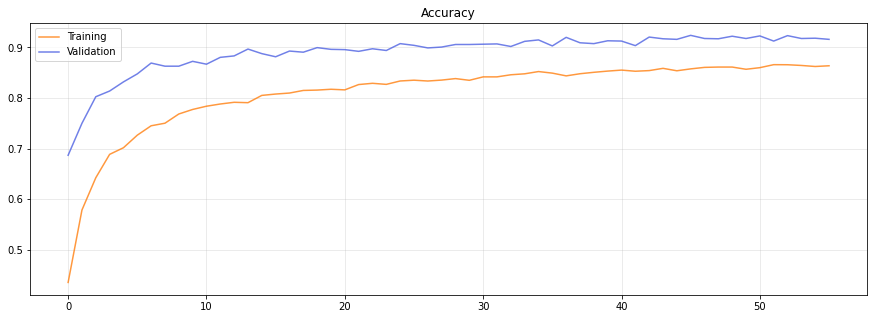

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#ff7f0e')
plt.plot(tl_history['val_loss'],  label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

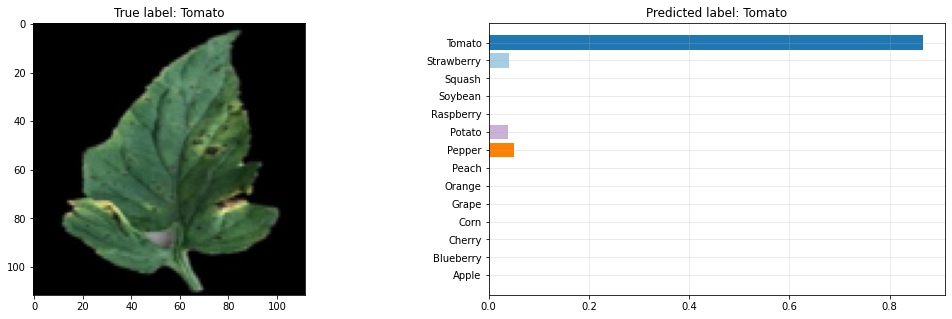

In [ ]:
# Plot the target images and the predictions
prediction_index = 100

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+label_dict[np.argmax(y_test[prediction_index])])
ax2.barh(list(label_dict.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+label_dict[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()

Accuracy: 0.7484
Precision: 0.7731
Recall: 0.6936
F1: 0.6884


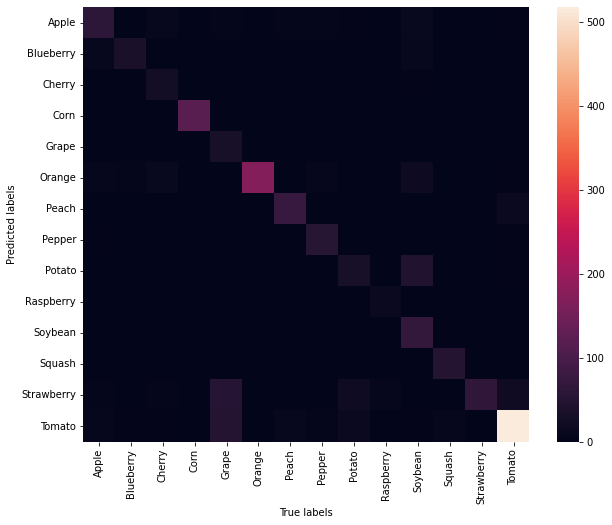

In [ ]:
# Predict the test set with the CNN
predictions = tl_model.predict(X_test)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the model with transfer learning
tl_model.save('TransferLearningD')
del tl_model

INFO:tensorflow:Assets written to: TransferLearningD/assets


INFO:tensorflow:Assets written to: TransferLearningD/assets


## Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningD')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 Flattening (Flatten)        (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                             

In [ ]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first 13t layers
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:13]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 112, 112, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.00005), metrics='accuracy')

Execution and evaluation 

In [ ]:
# Train the model

ft_history = ft_model.fit(
    training_generator, 
    epochs= epochs, 
    batch_size=batch_size,
    validation_data=validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
1773/1773 [==============================] - 123s 68ms/step - loss: 0.4967 - accuracy: 0.8576 - val_loss: 0.2378 - val_accuracy: 0.9357
Epoch 2/200
1773/1773 [==============================] - 120s 68ms/step - loss: 0.2462 - accuracy: 0.9312 - val_loss: 0.1257 - val_accuracy: 0.9662
Epoch 3/200
1773/1773 [==============================] - 120s 68ms/step - loss: 0.2012 - accuracy: 0.9456 - val_loss: 0.1474 - val_accuracy: 0.9526
Epoch 4/200
1773/1773 [==============================] - 119s 67ms/step - loss: 0.1624 - accuracy: 0.9569 - val_loss: 0.0935 - val_accuracy: 0.9763
Epoch 5/200
1773/1773 [==============================] - 119s 67ms/step - loss: 0.1373 - accuracy: 0.9633 - val_loss: 0.1344 - val_accuracy: 0.9684
Epoch 6/200
1773/1773 [==============================] - 119s 67ms/step - loss: 0.1420 - accuracy: 0.9640 - val_loss: 0.0996 - val_accuracy: 0.9741
Epoch 7/200
1773/1773 [==============================] - 119s 67ms/step - loss: 0.1311 - accuracy: 0.9671 - val_

In [ ]:
ft_model.save('FineTuningD')

INFO:tensorflow:Assets written to: FineTuningD/assets


INFO:tensorflow:Assets written to: FineTuningD/assets


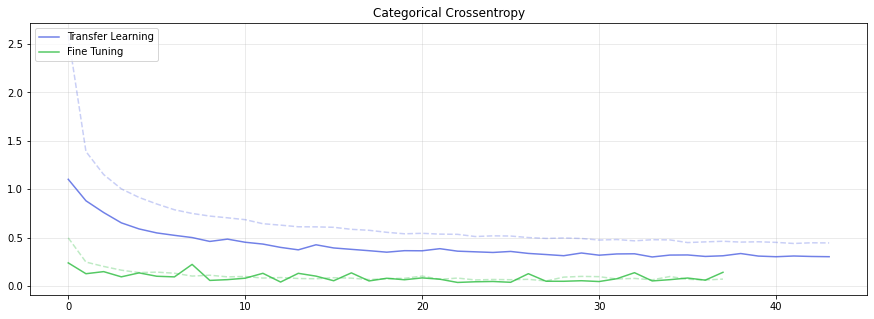

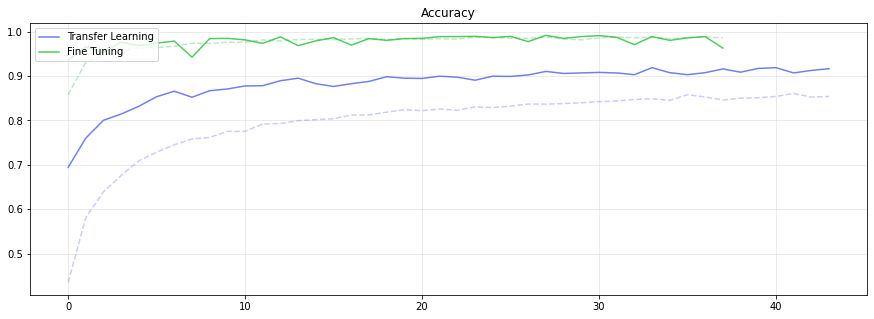

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.8494
Precision: 0.8742
Recall: 0.8583
F1: 0.8414


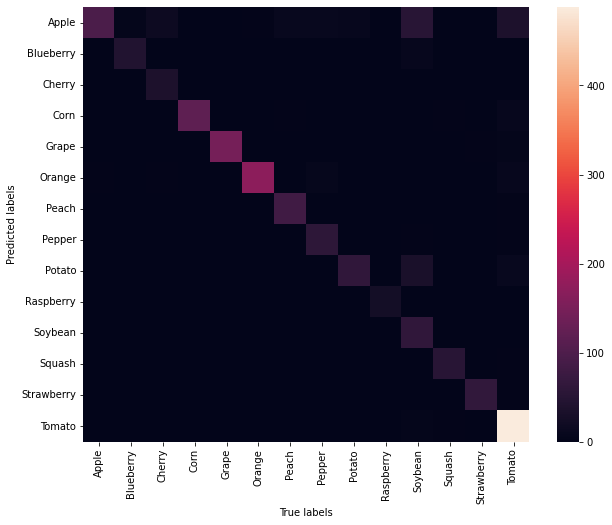

In [ ]:
# Predict the test set with the CNN
predictions = ft_model.predict(X_test)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()